# Calcification Detection In Mammograms

This is the official demo of the *SPIE 2021* paper: [Segmenting Microcalcifications in Mammograms and its Applications](https://arxiv.org/abs/2102.00811)

**Before we start**, to speed-up the computation time follow the following instructions:


1.   Go to *Runtime* In the top menu
2.   Choose *Change runtime type*
3.   Set *GPU* as *Hardware accelerator*
4.   Press Save


## Dowload code files

In [1]:
!git clone https://github.com/roeez/CalcificationDetection.git

Cloning into 'CalcificationDetection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 7
Receiving objects: 100% (11/11), 6.90 MiB | 27.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Import required libraries

In [2]:
from CalcificationDetection.core import *
from ipywidgets import interact
from functools import partial
from  ipywidgets.widgets import FloatSlider

Computation will be very slow! to speed-up computation in the top menu: Runtime->Change runtime type->GPU


# Telio: More import


In [3]:
import os
import numpy as np

import matplotlib.pyplot as plt
import math
from math import *
import cv2
import scipy
import time


#Trying new way of clusterisation
import sklearn
from scipy.spatial import distance
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AffinityPropagation, Birch, MiniBatchKMeans, AgglomerativeClustering, DBSCAN

#Characteristics list for HPV
import skimage
import pickle

## Run this cell to load a default mammogram for example

In [4]:
processed_mamm = load_mamm('CalcificationDetection/00001.png')

# Telio :  check and plot input


Image size: (3328, 1021)
Image type: float32


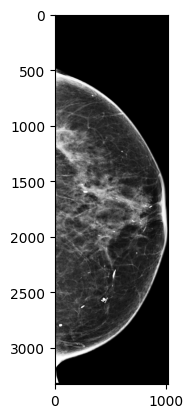

In [6]:
#check
print("Image size:",processed_mamm.shape)
print("Image type:",processed_mamm.dtype)

#plot
plt.close('all')
plt.figure()
plt.imshow(processed_mamm,cmap = plt.cm.gray)

## Run this cell to upload a mammogram
Not necessary if we want to use the pre-defined image :00001

In [15]:
processed_mamm = upload_mamm()

Saving EEC96467.png to EEC96467.png


## Run the model to detect calcifications









In [5]:
prediction = predict(model, processed_mamm)
#prediction = core.predict(core.model, mammog)

KeyboardInterrupt: ignored

# Telio: Check and plot result, superimpose microcalcifications detected on the mammogram


In [1]:
#Superimpose microcalcifications detected on the mammogram


#check
print("Image size:",prediction.shape)
print("Image type:",prediction.dtype)

# plot
plt.figure()
plt.imshow(prediction,cmap = plt.cm.gray)

NameError: ignored

# Telio: trying various modification for adaptation to algo 2 (HPV)


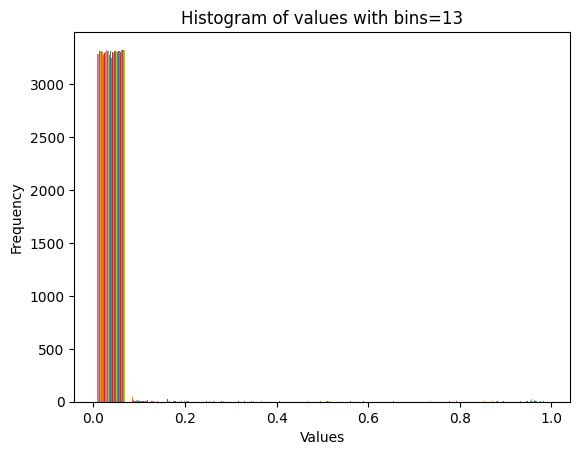

In [ ]:
## Choosing a threshold value

# Chosing bins value
N = len(prediction)

#Square root rule
#bins = int(np.ceil(np.sqrt(N)))

#Sturges rule
bins = int(np.ceil(np.log2(N) + 1))

# Basic
#bins=50


# Ploting hist
plt.hist(prediction, bins=bins)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f'Histogram of values with bins={bins}')

#Manual choice
threshold_value=0.4

In [ ]:
## First variation

threshold_value=0.

# Copy
imbin = np.copy(prediction)

# Binarization or Tresholding
imbin[imbin<threshold_value] = 0
imbin[imbin>= threshold_value] = 1

#Mask
prediction_modified = imbin * prediction

#Inversion
prediction_modified = 1 - prediction_modified



In [ ]:
## Second variation
threshold_value=0.4

# Copy
imbin2 = np.copy(prediction)

# Binarization or Tresholding
imbin2[imbin2<threshold_value] = 0
imbin2[imbin2>= threshold_value] = 1

#eventual fill holes
imbin2 = scipy.ndimage.binary_fill_holes(imbin2) * 1

#Mask
prediction_modified2 = imbin2 * prediction

#Inversion
prediction_modified2 = 1 - prediction_modified2


# Telio: Check and plot : Modified predict

In [ ]:
#check
print("Image 1 size :",prediction_modified.shape)
print("Image 1 type:",prediction_modified.dtype)

print("Image 2 size:",prediction_modified2.shape)
print("Image 2 type:",prediction_modified2.dtype)


# plot
plt.figure()
plt.title('binary image first modification ')
plt.imshow(imbin,cmap = plt.cm.gray)

plt.figure()
plt.title('binary image second modification ')
plt.imshow(imbin2,cmap = plt.cm.gray)

plt.figure()
plt.title('binary prediction first modification ')
plt.imshow(prediction_modified,cmap = plt.cm.gray)

plt.figure()
plt.title('binary prediction second modification ')
plt.imshow(prediction_modified2,cmap = plt.cm.gray)

NameError: ignored

# Telio: Trying other way of simple way of clusterisation


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Agglomerative time :0.8355906009674072


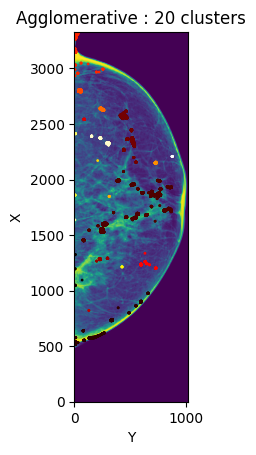

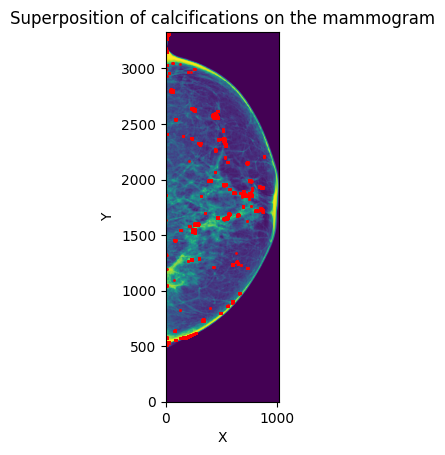

In [8]:
image = imbin2

clustering_choice = AgglomerativeClustering

# Locations of calcifications
regions = np.argwhere(image == 1)

# Matrix of distance between regions
dist_matrix = distance.cdist(regions, regions, metric='euclidean')



### Trying different to way to form clusters

if clustering_choice==AgglomerativeClustering or clustering_choice==0:
  ## Clusterisation using AgglomerativeClustering (pre-fixed number of calcifications)
  t0=time.time()
  n_clusters = 20
  clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='single')
  labels_agglo = clustering.fit_predict(dist_matrix)
  print(f"Agglomerative time :{time.time()-t0}")

if clustering_choice==DBSCAN or clustering_choice==0:
  ## Clusterisation using DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
  t0=time.time()
  epsilon = 10  # maximum distance between two samples for them to be considered as part of the same neighborhood (image size)
  min_samples = 4  # minimum number of samples in a neighborhood for a point to be considered a core point (density of points)
  clustering = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
  labels_dbs = clustering.fit_predict(dist_matrix)
  print(f"DBSCAN time :{time.time()-t0}")

if clustering_choice==KMeans or clustering_choice==0:
  ## Clusterisation using KMeans
  t0=time.time()
  n_clusters = 5
  clustering = KMeans(n_clusters=n_clusters)
  labels_KMeans = clustering.fit_predict(dist_matrix)
  print(f"Kmeans time :{time.time()-t0}")

if clustering_choice==MeanShift or clustering_choice==0:
  ## Clusterisation using MeanShify
  t0=time.time()
  clustering = MeanShift()
  labels_MeanShift = clustering.fit_predict(dist_matrix)
  print(f"MeanShifty time :{time.time()-t0}")

if clustering_choice==SpectralClustering or clustering_choice==0:
  ## Clusterisation using SpectralClustering
  t0=time.time()
  n_clusters = 5
  clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
  labels_SpectralClustering = clustering.fit_predict(dist_matrix)
  print(f"SpectralClustering time :{time.time()-t0}")

if clustering_choice==AffinityPropagation or clustering_choice==0:
  ## Clusterisation using AffinityPropagation
  t0=time.time()
  clustering = AffinityPropagation(affinity='precomputed')
  labels_AffinityPropagation = clustering.fit_predict(dist_matrix)
  print(f"Affinity time :{time.time()-t0}")

if clustering_choice==Birch or clustering_choice==0:
  ## Clusterisation using Birch
  t0=time.time()
  n_clusters = 5
  clustering = Birch(n_clusters=n_clusters)
  labels_Birch = clustering.fit_predict(dist_matrix)
  print(f"Birch time :{time.time()-t0}")

if clustering_choice==MiniBatchKMeans or clustering_choice==0:
  ## Clusterisation using MiniBatchKMeans
  t0=time.time()
  n_clusters = 5
  clustering = MiniBatchKMeans(n_clusters=n_clusters)
  labels_MiniBatchKMeans = clustering.fit_predict(dist_matrix)
  print(f"MinibatchKMeans time :{time.time()-t0}")


### Plots

if clustering_choice==AgglomerativeClustering or clustering_choice==0:
  ## AgglomerativeClustering
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_agglo, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title(f'Agglomerative : {n_clusters} clusters') #Clustering of calcification regions based on distance and pre-defined numbers of clusters:
  plt.show()

if clustering_choice==DBSCAN or clustering_choice==0:
  ## DBSCAN
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_dbs, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title(f'DBSCAN') #Clustering of calcification regions based on distance (DBSCAN)
  plt.show()

if clustering_choice==KMeans or clustering_choice==0:
  ## KMeans
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_KMeans, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('KMeans ')
  plt.show()

if clustering_choice==MeanShift or clustering_choice==0:
  ## MeanShift
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_MeanShift, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('MeanShift ')
  plt.show()

if clustering_choice==SpectralClustering or clustering_choice==0:
  ## SpectralClustering
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_SpectralClustering, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('SpectralClustering ')
  plt.show()

if clustering_choice==AffinityPropagation or clustering_choice==0:
  ## AffinityPropagation
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_AffinityPropagation, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('AffinityPropagation ')
  plt.show()

if clustering_choice==Birch or clustering_choice==0:
  ## Birch
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_Birch, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('Birch ')
  plt.show()

if clustering_choice==MiniBatchKMeans or clustering_choice==0:
  ## MiniBatchKMeans
  plt.imshow(processed_mamm)
  plt.scatter(regions[:, 1], regions[:, 0], c=labels_MiniBatchKMeans, cmap='hot', s=1)

  # Invert axes to adapt to the mammogram plot
  plt.gca().invert_yaxis()

  plt.xlabel('Y')
  plt.ylabel('X')
  plt.title('MiniBatchKMeans ')
  plt.show()



## Based Image to compare with
plt.imshow(processed_mamm)
index_points = np.argwhere(imbin2 == 1)
plt.scatter(index_points[:, 1], index_points[:, 0], color='red', marker='o', s=1)

# Invert axes to adapt to the mammogram plot
plt.gca().invert_yaxis()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Superposition of calcifications on the mammogram')
plt.show()


# Telio : Mean of the min


In [11]:
binary_image=imbin2
clustering_labels=labels_agglo

def calculate_minimal_distance_for_1_MC(labeled_image, region_label_1):
    # Boolean mask of the targeted MC (1) and the rest of MC
    region_1 = labeled_image == region_label_1
    other_regions = (labeled_image != region_label_1)*(labeled_image>0)

    # Find borders
    boundary_1 = skimage.segmentation.find_boundaries(region_1, mode='inner') #outer for 4 neighboors, inner for 8 neighboors
    other_boundaries = skimage.segmentation.find_boundaries(other_regions, mode='inner')

    # Maps of distance from the boundary of first MC
    distance_map = scipy.ndimage.distance_transform_edt(~boundary_1)
    # Find the minimal distance with the closest MC to boundary_1
    distance_between_boundaries = distance_map[other_boundaries].min()

    return distance_between_boundaries

#AMD  stands for Average Minimal Distance
def calculate_AMD_between_MC(binary_image,print_advance):
    current_time=time.time()
    labeled_image = skimage.measure.label(image)
    numbers_of_MC=np.amax(labeled_image)
    mean_of_min=0
    for label_index in range(0,numbers_of_MC):
        mean_of_min+=calculate_minimal_distance_for_1_MC(labeled_image,label_index+1)
        if time.time()-current_time>10 and print_advance:
          current_time=time.time()
          print('{}% done'.format(label_index*100//numbers_of_MC))
    mean_of_min=mean_of_min/numbers_of_MC
    return mean_of_min

def calculate_AMD_between_MC_of_a_specific_cluster(clustering_labels,binary_image,index_cluster_of_interest):
    mean_of_min_of_specific_cluster=0
    binary_image_of_specific_cluster = np.zeros_like(binary_image) #copy
    for i, label in enumerate(clustering_labels): # set the pixels of the calcifications not belonging to cluster_of_interest to 0
        if label == index_cluster_of_interest:
          y, x = regions[i]
          binary_image_of_specific_cluster[y, x] = 1
    mean_of_min_of_specific_cluster+=calculate_AMD_between_MC(binary_image_of_specific_cluster,False)
    return mean_of_min_of_specific_cluster

def calculate_AMD_between_MC_inside_clusters(clustering_labels,binary_image):
    regions = np.argwhere(binary_image == 1)
    number_of_cluster=max(clustering_labels)+1 #max+1 in fact but cluster index start from 0
    mean_of_min=0
    for index_cluster_of_interest in range(0,number_of_cluster):
        mean_of_min+=calculate_AMD_between_MC_of_a_specific_cluster(clustering_labels,binary_image,index_cluster_of_interest)
        print(f"Cluster done:{index_cluster_of_interest+1}/{number_of_cluster}, (the speed isn't continuous because of the size difference between clusters)")
    return mean_of_min/number_of_cluster

#def calculate_AMD_between_clusters


AMD_between_MC_inside_clusters = calculate_AMD_between_MC_inside_clusters(clustering_labels,binary_image)
print("mean_of_min_distance_between_MC_inside_clusters: {}".format(AMD_between_MC_inside_clusters))

AMD_between_MC = calculate_AMD_between_MC(binary_image,True)
print("mean_of_min_distance_between_MC: {}".format(AMD_between_MC))

Cluster done:1/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:2/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:3/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:4/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:5/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:6/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:7/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:8/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:9/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:10/20, (the speed isn't continuous because of the size difference between clusters)
Cluster done:11/20, (the speed isn't co

# Telio : Labeling



number of composantes: 144


Text(0.5, 1.0, 'Labeled image ')

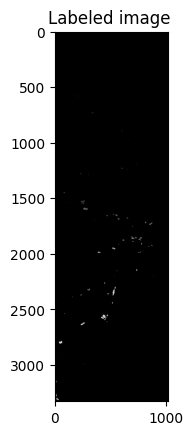

In [9]:
# Labeling
image=imbin2

label_image = skimage.measure.label(image)
nc = label_image.max()
print("number of composantes:", nc)

plt.figure()
plt.imshow(label_image,cmap = plt.cm.gray)
plt.title('Labeled image ')


#Telio : Making our own list of characteristics for HPV

In [15]:
class Calc_features :
    "microcalcifications HPV features"
    def __init__(self):
        self.Area = 0
        self.Centroid = 0
        self.MajorAxisLength = 0
        self.MinorAxisLength = 0
        self.Eccentricity = 0
        self.Orientation = 0
        self.EquivDiameter = 0
        self.Solidity = 0
        self.Perimeter = 0
        self.WeightedCentroid = 0 ##
        self.Circularity = 0
        self.EllipticalDeviation = 0
        self.MassDisplacement = 0
        self.IntegratedIntensity= 0
        self.MeanIntensity= 0
        self.IntensityDeviation= 0
        self.IntensityRange= 0

        self.MeanInsideBoundaryIntensity= 0 ##
        self.InsideBoundaryIntensityDeviation = 0 ##
        self.InsideBoundaryIntensityRange = 0 ##
        self.NormalizedInsideBoundaryIntensity = 0 ##

        self.MeanOutsideBoundaryIntensity= 0
        self.OutsideBoundaryIntensityDeviation = 0
        self.OutsideBoundaryIntensityRange = 0
        self.NormalizedOutsideBoundaryIntensity = 0

        self.BoundarySaliency = 0
        self.NormalizedBoundarySaliency = 0

    def print_fea(self):
        print('Area %d' % (self.Area))
        print('Centroid (%.2f %.2f)' % (self.Centroid))
        print('MajorAxisLength %.2f' % (self.MajorAxisLength ))
        print('MinorAxisLength %.2f' % (self.MinorAxisLength ))
        print('Eccentricitcy %.2f' % (self.Eccentricitcy))
        print('Orientation %.2f' % (self.Orientation))
        print('EquivDiameter %.2f' % (self.EquivDiameter))
        print('Solidity %.2f' % (self.Solidity))
        print('Perimeter %.2f' % (self.Perimeter))
        print('WeightedCentroid (%.2f %.2f)' % (self.WeightedCentroid))

        print('Circularity %.2f' % (self.Circularity))
        print('EllipticalDeviation %.2f' % (self.EllipticalDeviation))
        print('MassDisplacement %.2f' % (self.MassDisplacement))

        print('IntegratedIntensity %.2f' % (self.IntegratedIntensity))
        print('MeanIntensity %.2f' % (self.MeanIntensity))
        print('IntensityDeviation %.2f' % (self.IntensityDeviation))
        print('IntensityRange %.2f' % (self.IntensityRange))

    def print_addit_fea(self):
        print("\n")
        print('MeanInsideBoundaryIntensity %.2f' % (self.MeanInsideBoundaryIntensity) )
        print('InsideBoundaryIntensityDeviation %.2f' % (self.InsideBoundaryIntensityDeviation) )
        print('InsideBoundaryIntensityRange %.2f' % (self.InsideBoundaryIntensityRange) )
        print('NormalizedInsideBoundaryIntensity %.2f' % (self.NormalizedInsideBoundaryIntensity) )

        print('MeanOutsideBoundaryIntensity %.2f' % (self.MeanOutsideBoundaryIntensity) )
        print('OutsideBoundaryIntensityDeviation %.2f' % ( self.OutsideBoundaryIntensityDeviation) )
        print('OutsideBoundaryIntensityRange %.2f' % (self.OutsideBoundaryIntensityRange) )
        print('NormalizedOutsideBoundaryIntensity %.2f' % (self.NormalizedOutsideBoundaryIntensity) )

        print('BoundarySaliency %.2f' % (self.BoundarySaliency))
        print('NormalizedBoundarySaliency %.2f' % (self.NormalizedBoundarySaliency))


# Properties determination
# For matlab next step: *255
processed_mamm = processed_mamm*255
props = skimage.measure.regionprops(label_image,processed_mamm)

for region in props:

    #print("\n ==== region label : ", region.label)
    features_long_list = Calc_features()

    # fill attributs directly matlab to python
    features_long_list.Area = region.area
    features_long_list.Centroid = region.centroid
    features_long_list.MajorAxisLength = region.axis_major_length
    features_long_list.MinorAxisLength = region.axis_minor_length
    features_long_list.Eccentricicy = region.eccentricity

    features_long_list.Orientation = region.orientation
    features_long_list.EquivDiameter = region.equivalent_diameter_area
    features_long_list.Solidity = region.solidity
    features_long_list.Perimeter = region.perimeter
    features_long_list.WeightedCentroid = region.centroid_weighted

    # fill attributs light blue
    features_long_list.Circularity =  4 * math.pi * features_long_list.Area / (features_long_list.Perimeter**2)
    features_long_list.MassDisplacement = sqrt(sum((np.array(features_long_list.Centroid) - np.array( features_long_list.WeightedCentroid))**2)) / features_long_list.EquivDiameter

    # fill attributs dark blue
    # we use python if available
    lab = region.label
    regionNG = region.image_intensity
    regionMask = region.image_filled     #region.image
    pixelValues = regionNG * regionMask


    #not computed. Default value ????
    features_long_list.EllipticalDeviation = 0


    features_long_list.IntegratedIntensity= pixelValues.sum()
    features_long_list.MeanIntensity= pixelValues.mean()  #intensity_mean
    features_long_list.IntensityDeviation= pixelValues.std()
    features_long_list.IntensityRange= np.percentile(pixelValues,97.5) - np.percentile(pixelValues,2.5)

    #features_long_list.print_fea()

    # fill attributs violine

    se = skimage.morphology.disk(round(features_long_list.EquivDiameter/8))

    ero = skimage.morphology.binary_erosion(regionMask, footprint =se)
    insideBoundary = regionMask - 1*ero  # to get numerical and not boolean
    insideBoundaryValues = regionNG * insideBoundary;

    list_insideBoundaryValues = insideBoundaryValues[insideBoundary!=0]

    if len(list_insideBoundaryValues) > 0 :
    # inside boundary intensity statistics:
        features_long_list.MeanInsideBoundaryIntensity = list_insideBoundaryValues.mean()
        features_long_list.InsideBoundaryIntensityDeviation = list_insideBoundaryValues.std()
        features_long_list.InsideBoundaryIntensityRange = np.percentile(list_insideBoundaryValues,97.5) - np.percentile(list_insideBoundaryValues,2.5)
        features_long_list.NormalizedInsideBoundaryIntensity = features_long_list.MeanInsideBoundaryIntensity / features_long_list.MeanIntensity

    # outside boundary intensuty statistics:
    #Problems of value, not the best solution yet:
    regionMaskbis = np.copy(label_image)
    regionMaskbis[label_image != region.label] = 0
    regionMaskbis[label_image == region.label] =1
    #plt.figure()
    #plt.imshow(regionMaskbis )
    dil = skimage.morphology.binary_dilation(regionMaskbis, footprint =se)
    outsideBoundary = 1*dil - regionMaskbis

    outsideBoundaryValues = processed_mamm * outsideBoundary
    #plt.figure()
    #plt.imshow(outsideBoundaryValues  )

    # outside boundary intensuty statistics:
    list_outsideBoundaryValues = outsideBoundaryValues[outsideBoundary!=0]

    if len(list_outsideBoundaryValues) > 0 :
        features_long_list.MeanOutsideBoundaryIntensity = list_outsideBoundaryValues.mean()
        features_long_list.OutsideBoundaryIntensityDeviation = list_outsideBoundaryValues.std()
        features_long_list.OutsideBoundaryIntensityRange = np.percentile(list_outsideBoundaryValues, 97.5) - np.percentile(list_outsideBoundaryValues, 2.5)
        features_long_list.NormalizedOutsideBoundaryIntensity = features_long_list.MeanOutsideBoundaryIntensity / features_long_list.MeanIntensity

    features_long_list.BoundarySaliency = features_long_list.MeanInsideBoundaryIntensity - features_long_list.MeanOutsideBoundaryIntensity
    features_long_list.NormalizedBoundarySaliency = features_long_list.NormalizedInsideBoundaryIntensity - features_long_list.NormalizedOutsideBoundaryIntensity

    #features_long_list.print_addit_fea()





<ipython-input-15-5076f551258c>:95: RuntimeWarning: divide by zero encountered in double_scalars
  fea.Circularity =  4 * math.pi * fea.Area / (fea.Perimeter**2)


# Smaller characlist

number of MC: 144


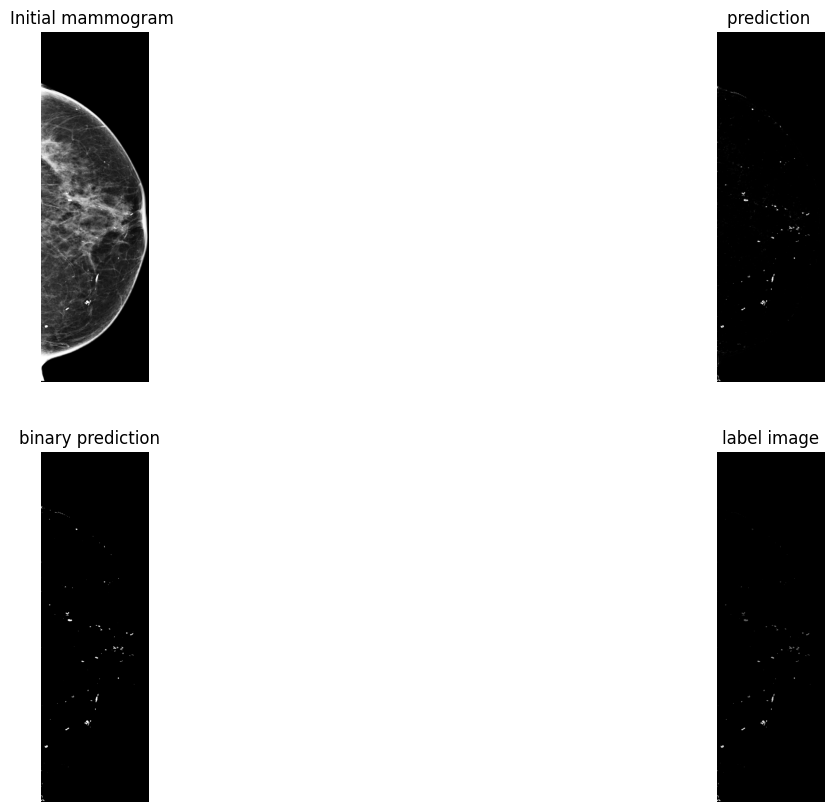

In [8]:
image=imbin2

plt.close('all')
fig = plt.figure(figsize=(16,10))
(ax1, ax2), (ax3,ax4) = fig.subplots(2, 2)

ax1.imshow(processed_mamm,cmap = plt.cm.gray)
ax1.set_title('Initial mammogram ')
ax1.set_axis_off()

ax2.imshow(prediction,cmap = plt.cm.gray)
ax2.set_title('prediction ')
ax2.set_axis_off()

ax3.imshow(imbin2,cmap = plt.cm.gray)
ax3.set_title('binary prediction  ')
ax3.set_axis_off()

label_image = skimage.measure.label(image)
nc = label_image.max()
print("number of MC:", nc)

ax4.imshow(label_image,cmap = plt.cm.gray)
ax4.set_title('label image')
ax4.set_axis_off()



 Number of MC kept for their characteristics (not too small): %d  116


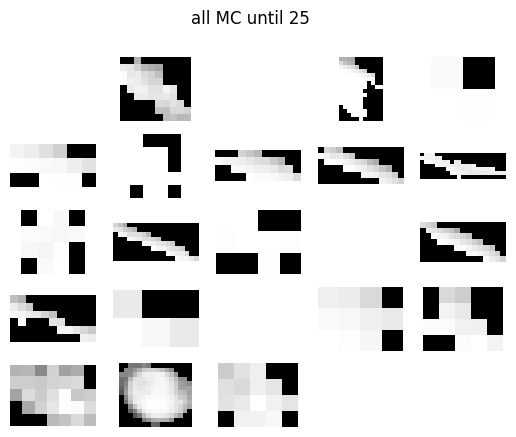

In [49]:
"""
 computation features
"""
features_list = []
features_list0 = []
MC_locations = []

class Features :
    "microcalcifications features"
    def __init__(self):
        self.Centroid = 0
        self.Area = 0
        self.Eccentricity = 0
        self.Solidity = 0
        self.Circularity = 0
        self.MajorAxisLength = 0
        self.MinorAxisLength = 0
        self.MeanIntensity= 0


    def print_features(self):
        print('Centroid (%.2f %.2f)' % (self.Centroid))
        print('Area %d' % (self.Area))
        print('Eccentricicy %.2f' % (self.Eccentricicy))
        print('Solidity %.2f' % (self.Solidity))
        print('Circularity %.2f' % (self.Circularity))
        print('MajorAxisLength %.2f' % (self.MajorAxisLength ))
        print('MinorAxisLength %.2f' % (self.MinorAxisLength ))
        print('MeanIntensity %.2f' % (self.MeanIntensity))



props = skimage.measure.regionprops(label_image,processed_mamm)

# prepare visu all MC
fig = plt.figure()
plt.suptitle('all MC until 25')
axs = fig.subplots(5, 5)
for k in range(25) :
    axs.flat[k].set_axis_off()



"""
loop on MC to construct features_list
"""

for region in props:

    #print("\n ==== MC or region label : ", region.label)

    # if the MC is too small we remove it
    if region.area < 2 or region.perimeter == 0 :
        a=1
        #print(" too small ! area : %d ", region.area)
    else :

        fea = Features()

        # fill attributs directly  python
        fea.Area =  region.area
        fea.Centroid = region.centroid
        fea.Eccentricicy = region.eccentricity

        fea.Solidity = region.solidity
        fea.Circularity =  4 * math.pi * region.area / (region.perimeter**2)
        fea.MajorAxisLength = region.axis_major_length
        fea.MinorAxisLength = region.axis_minor_length


        # fill attributs mammo
        fea.MeanIntensity= region.intensity_mean

        MC_mam = region.image_intensity
        MC_Mask = region.image_filled     #region.image
        pixelValues = MC_mam * MC_Mask

        #fea.MeanIntensity= pixelValues.mean()
        fea.IntensityRange= np.percentile(pixelValues,97.5) - np.percentile(pixelValues,2.5)

        #visu
        if region.label < 25 :
            axs.flat[region.label].imshow(pixelValues,cmap = plt.cm.gray)


        # matlab adaptation
        x = fea.Centroid[0]
        y = fea.Centroid[1]
        fea.Centroid = (y+1 , x+1)

        #fea.print_features()

        features_list.append(fea)


        features_list0.append(y+1)
        features_list0.append(x+1)
        features_list0.append(fea.Area)
        features_list0.append(fea.Eccentricicy)
        features_list0.append(fea.Solidity)
        features_list0.append(fea.Circularity)
        features_list0.append(fea.MajorAxisLength)
        features_list0.append(fea.MinorAxisLength)
        features_list0.append(fea.MeanIntensity)

        temporary=[]
        for coord in region.coords:
            temporary.extend(coord+1)
        #MC_locations.append(round(len(temporary)/2)) # the number of pixels is added in head
        MC_locations.extend(temporary) # the pixels are added
        MC_locations.append(0) # to separate each region


print("\n Number of MC kept for their characteristics (not too small): %d " ,len(features_list))
MC_locations.insert(0,len(features_list)) # number of MC kept


# Telio : Only if you are using Google Drive

In [12]:
from google.colab import drive

# Google drive mount
drive.mount('/content/drive')

## Directory path on Google Drive
directory_path_img = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Saved_Images"
#directory_path_img = put your own path
directory_path_characteristics = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Saved_characteristics "
#directory_path_characteristics = put your own path

# Check if the directory exists, create it if not
if not os.path.exists(directory_path_img):
    os.makedirs(directory_path_img)
if not os.path.exists(directory_path_characteristics):
    os.makedirs(directory_path_characteristics)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Telio : new data base load, transform and save

In [4]:
!pip install pydicom


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00


In [13]:
import os
import pydicom
from PIL import Image
import numpy as np

input_folder = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Inpt/dicoms"
output_folder = "/content/drive/MyDrive/Colab_Notebooks/HMU_Internship_Telio/CalcificationDetection_Initial/Dicoms"
# Crée le répertoire de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith('.dcm'):
        print(f"Traitement du fichier {filename}")  # Affiche le nom du fichier en cours de traitement
        try:
            # Charge le fichier DICOM
            path = os.path.join(input_folder, filename)
            ds = pydicom.dcmread(path)

            # Convertit l'image DICOM en PIL Image
            im = Image.fromarray(ds.pixel_array)

            # Convertit l'image en 8 bits
            image_16bit = np.array(im)
            image_8bit = ((image_16bit - image_16bit.min()) / (image_16bit.ptp() / 255.0)).astype(np.uint8)
            image_8bit = 255 - image_8bit  # Inverse l'échelle de gris
            im_8bit = Image.fromarray(image_8bit)

            # Enregistre l'image au format JPG
            new_filename = os.path.splitext(filename)[0] + '.png'  # Ajoute l'extension '.jpg' au nom de fichier
            im_8bit.save(os.path.join(output_folder, new_filename), "PNG")
            print(f"Image sauvegardée : {new_filename}")  # Affiche le nom de l'image sauvegardée
        except Exception as e:
            print(f"Erreur lors du traitement du fichier {filename}: {e}")  # Affiche toute erreur survenue
    else:
        print(f"Le fichier {filename} n'est pas un fichier .dcm")  # Affiche un message si le fichier n'est pas un fichier .dcm

Traitement du fichier EE0CA937.dcm
Image sauvegardée : EE0CA937.png
Traitement du fichier EE333477.dcm
Image sauvegardée : EE333477.png
Traitement du fichier EE503A67.dcm
Image sauvegardée : EE503A67.png
Traitement du fichier EE61BA1D.dcm
Image sauvegardée : EE61BA1D.png
Traitement du fichier EE632566.dcm
Image sauvegardée : EE632566.png
Traitement du fichier EEB00A05.dcm
Image sauvegardée : EEB00A05.png
Traitement du fichier EEC96467.dcm
Image sauvegardée : EEC96467.png


# Telio: save features list for HPV

In [50]:
file_path_features = os.path.join(directory_path_characteristics, 'features_list.txt') # features_long_list
file_path_MClocations = os.path.join(directory_path_characteristics, 'MC_locations_list.txt') # features_long_list

# Save the list of features to the text file
with open(file_path_features, 'w') as file:
    for num in features_list0:
        file.write(str(num) + '\n')

# Save the list of MC_locations to the text file
with open(file_path_MClocations, 'w') as file:
    for num in MC_locations:
        file.write(str(num) + '\n')

# Telio: Save images for algo 2 (HPV)

In [ ]:


#Loaded mammog
file_path1 = os.path.join(directory_path_img, "input.tif")

#First prediction
file_path2 = os.path.join(directory_path_img, "ouput_CALC1.tif")

#Modified predictions
file_path3 = os.path.join(directory_path_img, "Modified_ouput_CALC1.tif")

file_path7 = os.path.join(directory_path_img, "Modified_ouput2_CALC1.tif")

#PNG format
file_path4 = os.path.join(directory_path_img, "input.png")
processed_mamm_p = processed_mamm * 255

file_path5 = os.path.join(directory_path_img, "ouput_CALC1.png")
prediction_p = prediction * 255

file_path6 = os.path.join(directory_path_img, "Modified_ouput_CALC1.png")
prediction_modified_p = prediction_modified * 255

file_path8 = os.path.join(directory_path_img, "Modified_ouput2_CALC1.png")
prediction_modified2_p = prediction_modified2 * 255


# Saving
cv2.imwrite(file_path1, processed_mamm)
cv2.imwrite(file_path2, prediction)
cv2.imwrite(file_path3, prediction_modified)
cv2.imwrite(file_path7, prediction_modified2)
cv2.imwrite(file_path4, processed_mamm_p)
cv2.imwrite(file_path5, prediction_p)
cv2.imwrite(file_path6, prediction_modified_p)
cv2.imwrite(file_path8, prediction_modified2_p)

True

## Show results

Use the slide bar to change threshold of the results (it can take about 30 secs to show the updated results)

In [2]:
foo = partial(show_mamm_w_boxes, processed_mamm, prediction)
#foo = partial(show_mamm_w_boxes, processed_mamm, prediction_modified)
foo.__name__ = "foo"
interact(foo, th=FloatSlider(min=0, max=1, step=.01, value=.5));

NameError: ignored